# Классификация изображений Fashion MNIST

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt

In [3]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d23d2308-706b-f806-0814-c144436f3670)
GPU 1: Tesla T4 (UUID: GPU-ac919d52-980a-65d7-98bd-b4a4da71c06b)


In [5]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

Fri May 17 15:06:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0              29W /  70W |    103MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# MNIST

In [6]:
# скачиваем данные
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# что за данные
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[9 0 0 3 0 2 7 2 5 5]
[9 2 1 1 6 1 4 6 5 7]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


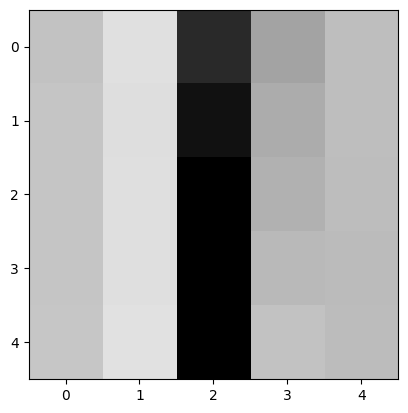

Пример картинки:


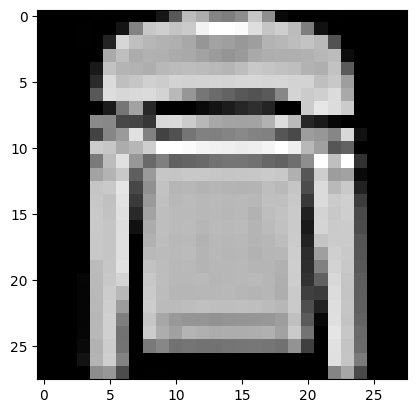

y_train [shape (60000,)] 10 примеров:
 [9 0 0 3 0 2 7 2 5 5]


In [8]:
# нарисуем картинку
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

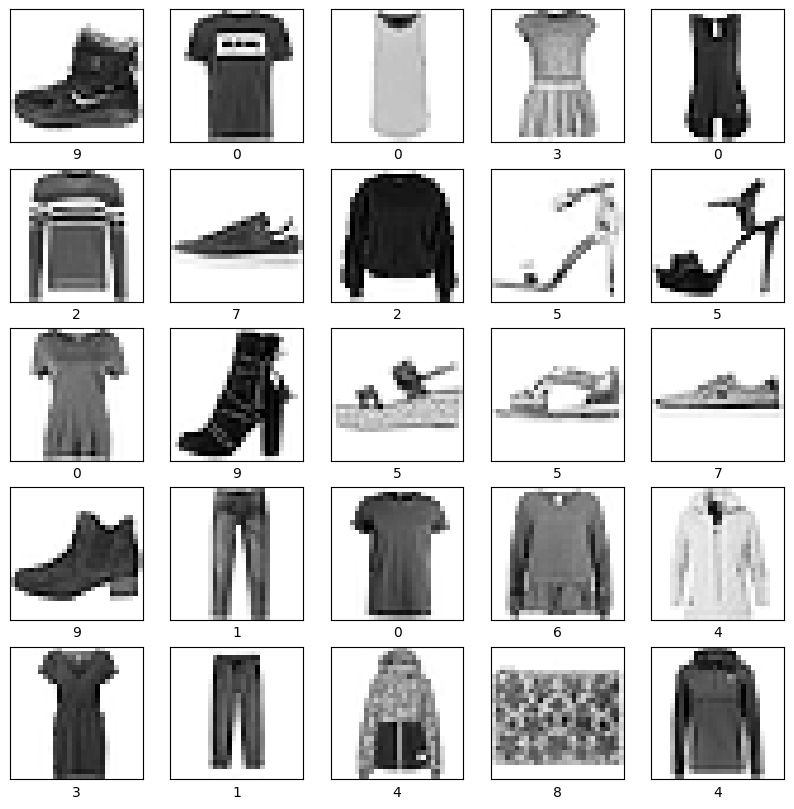

In [9]:
# Посмотрим побольше примеров
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(y_train[i])
plt.show()

# Data

In [10]:
# вытянем картинку в вектор размера 28*28=784 и будем использовать это как фичи!

x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train.shape, x_train_flat.shape)

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)


In [11]:
# центрируем и нормируем, так сети будет проще учиться
# x_train_float = x_train_flat.astype(np.float32) / 255 - 0.5
# x_val_float = x_val_flat.astype(np.float32) / 255 - 0.5

# по сути, это действия аналогичны нормализации через StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_flat = scaler.fit_transform(x_train_flat)
x_val_flat = scaler.transform(x_val_flat)

# Но попробуйте пропустить нормирование и посмотрите что будет ;)
# x_train_float = x_train_flat.astype(np.float)
# x_val_float = x_val_flat.astype(np.float)

In [12]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9 0 0 3 0]


# Собираем модель

Самостоятельно постойте Multi layer Perceptron (MLP) классификатор (по аналогии с практическеской частью, но на новых данных)

In [91]:
clear_session()

In [92]:
# Архитектура сети
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(x_train_flat.shape[1],),
                kernel_constraint=MaxNorm(3),)) # первый скрытый слой
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu',
                kernel_constraint=MaxNorm(3))) # второй скрытый слой
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu',
                kernel_constraint=MaxNorm(3))) # второй скрытый слой
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax',)) # выходной слой

In [93]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,314 (930.91 KB)

 Trainable params: 238,314 (930.91 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [95]:
history = model.fit(
    x_train_flat,
    y_train_oh,
    batch_size=32,  # 32 объекта для подсчета градиента на каждом шаге
    epochs=50,  # 50 проходов по датасету
    validation_data=(x_val_flat, y_val_oh)
)

Epoch 1/50
  79/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3575 - loss: 1.9557

W0000 00:00:1715960478.241657     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7041 - loss: 0.8578

W0000 00:00:1715960482.165143     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7043 - loss: 0.8571 - val_accuracy: 0.8422 - val_loss: 0.4466
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8253 - loss: 0.4874 - val_accuracy: 0.8517 - val_loss: 0.4100
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8432 - loss: 0.4399 - val_accuracy: 0.8602 - val_loss: 0.3896
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8454 - loss: 0.4276 - val_accuracy: 0.8649 - val_loss: 0.3756
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8558 - loss: 0.4012 - val_accuracy: 0.8636 - val_loss: 0.3709
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8630 - loss: 0.3773 - val_accuracy: 0.8644 - val_loss: 0.3734
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8680 - loss: 0.3728 - val_accuracy: 0.8667 - val_loss: 0.3576
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8701 - loss: 0.3594 - val_accura

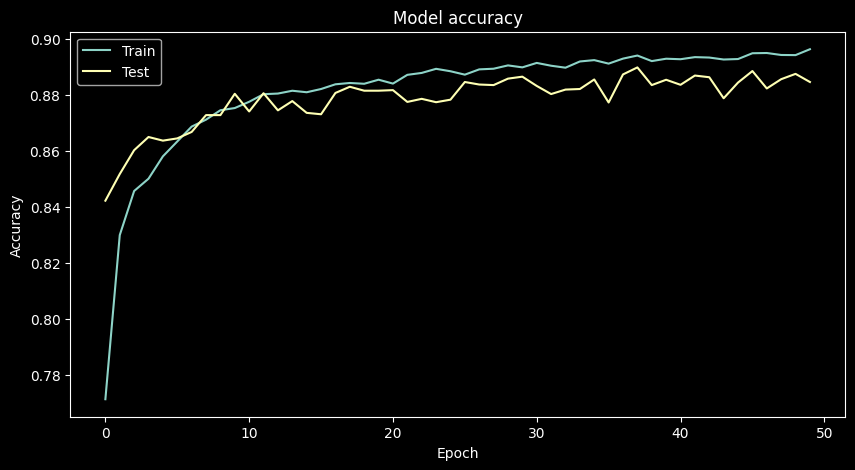

In [96]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

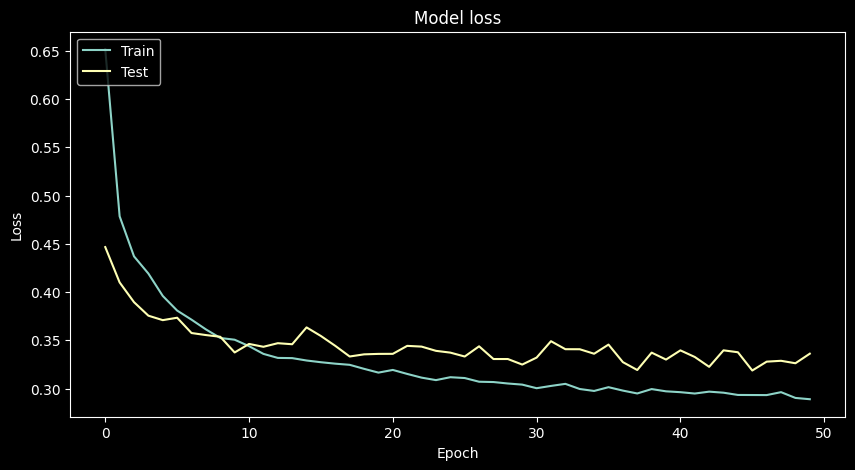

In [97]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [99]:
predicts = np.argmax(model.predict(x_val_flat), axis = 1)
print(metrics.classification_report(y_val, predicts, digits=5))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0    0.83992   0.82900   0.83442      1000
           1    0.98081   0.97100   0.97588      1000
           2    0.82961   0.77900   0.80351      1000
           3    0.86291   0.91900   0.89007      1000
           4    0.81010   0.80200   0.80603      1000
           5    0.97708   0.93800   0.95714      1000
           6    0.69688   0.71500   0.70582      1000
           7    0.94221   0.96200   0.95200      1000
           8    0.97681   0.96900   0.97289      1000
           9    0.93301   0.96100   0.94680      1000

    accuracy                        0.88450     10000
   macro avg    0.88493   0.88450   0.88446     10000
weighted avg    0.88493   0.88450   0.88446     10000



Предсказание классов одежды по низкоразмерным иконкам, как видим, для полносвязных нейронных сетей уже задача более трудная, чем классификация рукописных цифр.